In [1]:
# import packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') # supress warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [2]:
# data extracted from https://www.kaggle.com/datasets/PromptCloudHQ/imdb-data
# read the data
df = pd.read_csv("IMDB-Movie-Data.csv")

In [3]:
# display data
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


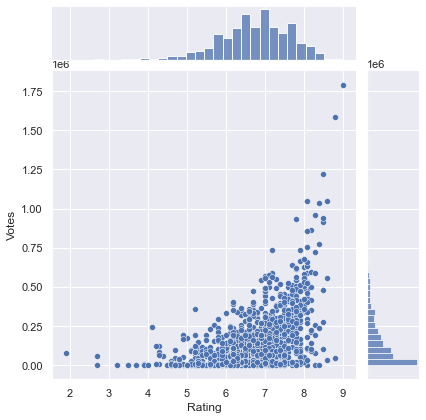

In [4]:
# visualizing the data set to identify the distribution of the data
sns.set(rc={'figure.figsize':(10,5)})
sns.jointplot(x = 'Rating', y = 'Votes', data = df)

In [5]:
def content_based_recommender(Title):
    
    Title = str(Title)
    if Title in df['Title'].values:
        # we filter the rare movies (lowly voted movies) from the rest
        rare_movies = df[df['Votes'].values <= 5000]['Title'].values
        common_movies = df[~df['Title'].isin(rare_movies)]
        
        if Title in rare_movies:
            
            # rare movies cannot be used for content based filtering as they might affect our matrix
            random = pd.Series(common_movies['Title'].unique()).sample(2).values # two common movies are suggested
            print('There are no recommendations for this movie')
            print('Try: \n') 
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            
            common_movies = common_movies.drop_duplicates(subset=['Title']) # removing duplicates, if any
            common_movies.reset_index(inplace= True)
            common_movies['index'] = [i for i in range(common_movies.shape[0])]
            # we are using Title, Director, Actors and Genre for the filtering
            target_cols = ['Title','Director','Actors','Genre']
            common_movies['combined_features'] = [' '.join(common_movies[target_cols].iloc[i,].values) for i in range(common_movies[target_cols].shape[0])]
            # print(common_movies['combined_features'])
            cv = CountVectorizer()
            # features are transformed into vectors using count vectorizer
            count_matrix = cv.fit_transform(common_movies['combined_features'])
            # print(count_matrix)
            # we find out the cosine similarity between two vectors
            cosine_sim = cosine_similarity(count_matrix)
            # print(cosine_sim)
            index = common_movies[common_movies['Title'] == Title]['index'].values[0]
            # the cosine similarity values are enumerated using the index of the movies data frame
            sim_movies = list(enumerate(cosine_sim[index]))
            # print(sim_movies)
            # movies are sorted depending on maximum similarity, we pick top 5
            sorted_sim_movies = sorted(sim_movies,key=lambda x:x[1],
                                      reverse=True)[1:6]
            # print(sorted_sim_movies)
            # print(common_movies.iloc[559])
            
            movies = []
            for i in range(len(sorted_sim_movies)):
                # we return the titles of the recommended movies
                movies.append(common_movies[common_movies['index'] == sorted_sim_movies[i][0]]['Title'].item())
            return movies
                                     
    else:
        
        print('Cant find movie in dataset, please check spelling')
        return null

In [6]:
movies = content_based_recommender('Inception')
movies

['Godzilla', 'Interstellar', 'Tron', 'Don Jon', 'Battleship']

In [7]:
print('You may also like these movies')
df[df['Title'].isin(movies)]

You may also like these movies


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
36,37,Interstellar,"Adventure,Drama,Sci-Fi",A team of explorers travel through a wormhole ...,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",2014,169,8.6,1047747,187.99,74.0
256,257,Battleship,"Action,Adventure,Sci-Fi",A fleet of ships is forced to do battle with a...,Peter Berg,"Alexander Skarsgård, Brooklyn Decker, Liam Nee...",2012,131,5.8,210349,65.17,41.0
528,529,Godzilla,"Action,Adventure,Sci-Fi",The world is beset by the appearance of monstr...,Gareth Edwards,"Aaron Taylor-Johnson, Elizabeth Olsen, Bryan C...",2014,123,6.4,318058,200.66,62.0
577,578,Tron,"Action,Adventure,Sci-Fi",The son of a virtual world designer goes looki...,Joseph Kosinski,"Jeff Bridges, Garrett Hedlund, Olivia Wilde, B...",2010,125,6.8,273959,172.05,49.0
614,615,Don Jon,"Comedy,Drama,Romance","A New Jersey guy dedicated to his family, frie...",Joseph Gordon-Levitt,"Joseph Gordon-Levitt, Scarlett Johansson,Julia...",2013,90,6.6,199973,24.48,66.0
